<div style="text-align: center;">
<strong>Machine Learning for Scientific Computing and Numerical Analysis - PC 1</strong>
</div>
<div style="text-align: center;">
<strong>Linear and nonlinear regression - 1</strong>
</div>
<div style="text-align: center;">
<p>Loïc Gouarin, Samuel Kokh, Hadrien Montanelli</p>
</div>
<div style="text-align: center;">
<i>2024 - 2025</i>
</div>

In this first PC, we will explore various regression methods using datasets that we generate ourselves. The goal is to understand how the characteristics of these datasets influence the solution to the supervised learning problem.

# Import the Python modules used

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# Datasets
We will start by presenting several datasets that will be used throughout this notebook. You can add your own dataset by adding an entry in the following function.

In [2]:
def get_dataset(datatype, n, d, eta, random_gen=np.random.rand):
    np.random.seed(42)
    x = -1 + 2 * random_gen(n, d)
    if datatype == "linear":
        w_linear = np.ones(d)
        y = x @ w_linear + eta * random_gen(n)
    elif datatype == "logist":
        w_logistic = 3 * np.ones(d)
        y = 1 / (1 + np.exp(-x @ w_logistic)) + eta * random_gen(n)
    elif datatype == "sphere":
        y = np.linalg.norm(x, axis=1) + eta * random_gen(n)
    elif datatype == "normal":
        mean = np.zeros(d)
        covariance = np.eye(d) / d
        mvn = multivariate_normal(mean=mean, cov=covariance)
        y = mvn.logpdf(x) + eta * random_gen(n)
    y /= np.max(np.abs(y))
    return x, y

Let’s examine the data and observe how a random perturbation impacts its quality. To make it possible to visualize the solutions in 2D, we will assume for now that there is only one weight $w$ (i.e., dimension $d=1$). This will no longer be the case when we are interested in solving the problem.

In [ ]:
from plot_dataset import create_plot_dataset_container

create_plot_dataset_container(get_dataset)

ERROR: Could not find a version that satisfies the requirement plot-dataset (from versions: none)
ERROR: No matching distribution found for plot-dataset


Note: you may need to restart the kernel to use updated packages.


ModuleNotFoundError: No module named 'plot_dataset'

# 1 Linear least squares

As explained in the first lecture, we want to minimize

$$
\Vert X\bm{w} - \bm{y}\Vert_2^2,
$$

where the rows of $X$ represent one sample. Suppose we have $n$ samples and we try to find $d$ weights, then the $X$ matrix is of size $(n , d)$. The optimal weights are obtained by solving the normal equations

$$
X^TX\bm{w} = X^T\bm{y}.
$$

Various methods are available for solving this linear system (QR, SVD, iterative methods, ...). In the following, we will focus on the QR factorization $X=QR$, where $Q$ is an orthogonal matrix and $R$ is an upper-triangular matrix.

The construction of $Q$ can be done using the Gram-Schmidt algorithm, which can be described as follows.

:::{prf:algorithm} Gram-Schmidt
:label: gram-schmidt

**Input** A list of vectors $\{v_1,v_2,\cdots,v_d\}$ corresponding to the columns of $X$.

**Output** A list of orthonormal vectors $\{q_1,q_2,\cdots,q_d\}$ correponsding to the columns of $Q$.

**Steps**

1. Initialize an empty matrix $Q$ to store the orthonormal vectors.
2. For each vector $v_i$, $i=1,2,\ldots,d$:
   - Start with $q_i = v_i$.
   - Subtract the projections of $q_i$ onto all previously computed orthogonal vectors $q_j$ (for $j=1,2,\cdots,i−1)$.
   - Normalize $q_i$ by dividing by its norm.
3. Append each orthonormal vector $q_i$ to $Q$.
4. Return the matrix $Q$ of orthonormal vectors.

**Notes**

- The projection of $v_i$ onto $q_j$ is calculated as $P_{q_j}(v_i)=(v_i^Tq_j)q_j$.

- After orthogonalizing $v_i$, it can be normalized by dividing by its norm to get an orthonormal vector.
:::


In the next cell, we provide a partial implementation of the Gram-Schmidt algorithm, leaving out the projection step. *(Note: This simple implementation is numerically unstable and may perform poorly when the matrix is ill-conditioned. In such cases, a modified Gram-Schmidt algorithm should be used.)*

In [4]:
def gram_schmidt(A):
    Q = np.empty_like(A)
    for i in range(A.shape[1]):
        q = np.copy(A[:, i])
        for j in range(i):
            q-=(Q[:, j].T @ A[:, i]) * Q[:, j]
        q /= np.sqrt(q.T @ q)
        Q[:, i] = q
    return Q

{exercise}
Write the second step of the algorithm, specifically the part where you have *Part to code*. In other words: *Subtract the projections of $v_i$ onto all previously computed orthonormal vectors $q_j$ (for $j=1,2,\cdots,i−1)$.*

{exercise}
Validate your algorithm using the following matrix

$$
A = \left[
\begin{array}{ccc}
1 & 1 & 1 \\
-1 & 0 & 1 \\
1 & 1 & 2
\end{array}
\right].
$$

You can use the `qr` method provided in `numpy.linalg` to check the result.


In [5]:
#exercice 2
A = np.array([
    [1, 1, 1],
    [-1, 0, 1],
    [1, 1, 2]
], dtype=float)
Q = gram_schmidt(A)
Q2, R2 = np.linalg.qr(A)

print(Q)
print(Q2)

[[ 0.57735027  0.40824829 -0.70710678]
 [-0.57735027  0.81649658  0.        ]
 [ 0.57735027  0.40824829  0.70710678]]
[[-0.57735027 -0.40824829 -0.70710678]
 [ 0.57735027 -0.81649658  0.        ]
 [-0.57735027 -0.40824829  0.70710678]]


{exercise}
Write a `QR_factorization` function, which outputs both $Q$ and $R$.

In [6]:
#exercice 3
def QR_factorization(A):
    Q=gram_schmidt(A)
    R=Q.T@A
    return Q,R

Q,R =  QR_factorization(A)
Q2, R2 = np.linalg.qr(A)

print("QR_factorization fonction:")
print("Q:")
print(Q)
print("\nR :")
print(R)

print("\nNumPy Implementation:")
print("Q:")
print(Q2)
print("\nR:")
print(R2)

QR_factorization fonction:
Q:
[[ 0.57735027  0.40824829 -0.70710678]
 [-0.57735027  0.81649658  0.        ]
 [ 0.57735027  0.40824829  0.70710678]]

R :
[[ 1.73205081e+00  1.15470054e+00  1.15470054e+00]
 [-6.66133815e-16  8.16496581e-01  2.04124145e+00]
 [ 1.11022302e-15  1.11022302e-15  7.07106781e-01]]

NumPy Implementation:
Q:
[[-0.57735027 -0.40824829 -0.70710678]
 [ 0.57735027 -0.81649658  0.        ]
 [-0.57735027 -0.40824829  0.70710678]]

R:
[[-1.73205081 -1.15470054 -1.15470054]
 [ 0.         -0.81649658 -2.04124145]
 [ 0.          0.          0.70710678]]


The QR factorization can be computed in $\mathcal{O}(2nd^2)$ operations with Gram-Schmidt orthogonalization.

{exercise}
Verify the complexity of the algorithm using the following function.

In [7]:
import time


def computation_time(n, d):
    exec_time = []
    for i in n:
        for j in d:
            A = np.random.rand(i, j)
            t0 = time.time()
            QR_factorization(A)
            t1 = time.time()
            exec_time.append(t1 - t0)
    return exec_time

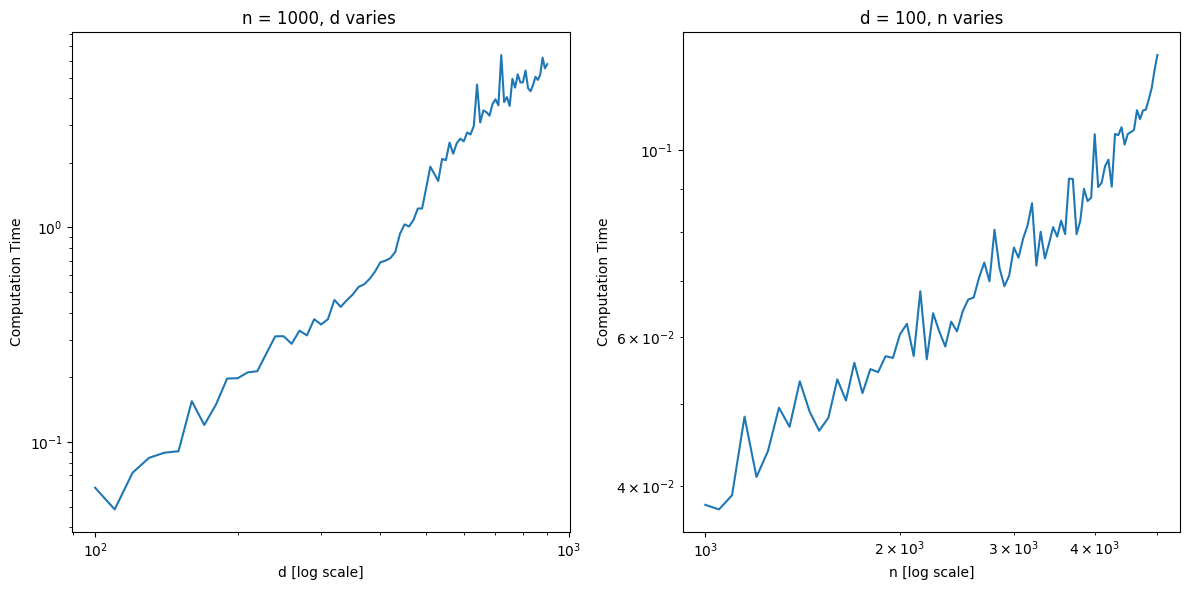

In [8]:
#exercice 4

# 1st graph: n = 1000
n_fixe = [1000]
d_values = np.arange(100, 901, 10)
time_fixed_n = computation_time(n_fixe, d_values)

# 2nd graph: d = 100
d_fixe = [100]
n_values = np.arange(1000, 5001, 50)
time_fixed_d = computation_time(n_values, d_fixe)


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(d_values, time_fixed_n)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('d [log scale]')
plt.ylabel('Computation Time')
plt.title('n = 1000, d varies ')


plt.subplot(1, 2, 2)
plt.plot(n_values, time_fixed_d)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('n [log scale]')
plt.ylabel('Computation Time')
plt.title('d = 100, n varies')

plt.tight_layout()
plt.show()

**Comment on Exercise 4:**

**Analysis of the Results**

On the **left graph**, the curve appears to follow a **linear relationship** with $log(d)$. Additionally, without the log scale, the relationship is quadratic with $d$. These results are consistent with the theoretical complexity $O(2n d^2)$.

On the **right graph**, a **linear relationship** with $log(n)$ is also observed, which is similarly consistent.



We can now solve the normal equations via

$$
R\bm{w} = Q^T\bm{y}.
$$

Since $R$ is an upper-triangular matrix, we can compute $\bm{w}$ using back substitution. The function below is a step-by-step solution for solving linear least sqaures with QR factorization (refer to *Algorithm 1* in the first lecture).

In [9]:
def solve_linear_least_squares(X, y):
    Q, R = QR_factorization(X)
    b = Q.T @ y
    w = np.empty(X.shape[1])
    for i in range(X.shape[1] - 1, -1, -1):
        w[i] = (b[i] - np.sum(w[i + 1 :] * R[i, i + 1 :])) / R[i, i]
    return w


def solve_linear_least_squares_np(X, y):  # implementation with built-in numpy functions
    Q, R = np.linalg.qr(X)
    w = np.linalg.solve(R, Q.T @ y)
    return w


X = np.random.rand(1000, 100)
y = np.ones(1000)
w = solve_linear_least_squares(X, y)
w_np = solve_linear_least_squares_np(X, y)
print(np.linalg.norm(w - w_np))

9.149164705644457e-15


The supervised learning problem can now be solved using the previous function. Next, we will examine the robustness of this algorithm in determining the optimal weights for the datasets under consideration.

In [10]:
from plot_dataset import create_plot_error_container

create_plot_error_container(get_dataset, solve_linear_least_squares)

{exercise}
What do you observe? Comment.

### Comments on exercice 5:

1. **Linear Dataset**:  
   - As the perturbation increases, the error grows steadily. Thus, the algorithm is sensitive to data perturbation.

2. **Logistic, Spherical and Normal Datasets**:  
   - The error remains constant despite the perturbation of the data. It may signifies that the algorithm is robust for these datasets, as the perturbations have minimal impact.


# 2 Nonlinear least squares

In the previous section, we explored how to solve a linear regression problem. We found that the solution works well for linear data but fails for nonlinear data. To achieve good results with nonlinear data, an additional step is necessary.

Various methods exist to solve nonlinear regression problems. We compare two of them:

- Gauss-Newton's method with QR factorization;
- Newton's method.

Both methods aim to minimize

$$
\Vert\hat{\bm{y}}(\bm{w}) - \bm{y}\Vert_2^2 \qquad \text{where} \qquad \hat{\bm{y}}(\bm{w}) = (\hat{f}(\bm{x}_1;\bm{w}),\ldots,\hat{f}(\bm{x}_n;\bm{w}))^T,
$$

for some function model $\hat{f}$. We start with Gauss-Newton's method with QR factorization.

## 2.1 Gauss-Newton's method with QR

{prf:algorithm}Gauss-Newton's method with QR

**Inputs**

- $\hat{f}$: the function model.
- $J$: the Jacobian of $\hat{f}$ with respect to $\bm{w}$.
- $\{\bm{x}_i,y_i\}_{i=1}^n$: the data points.
- $\bm{w^0}$: the initial guess.

**Output** The optimal weights $\bm{w}$.

**Steps**

1. Compute the Jacobian $J^k=J(\bm{w}^k)$ and evaluate the prediction $\hat{\bm{y}}(\bm{w}^k)$.
2. Compute the vector $\bm{r}^k = \hat{\bm{y}}(\bm{w}^k) - \bm{y}$ .
2. Solve the linearized normal equations $(J^k)^TJ^k\bm{s}^k=−(J^k)^T\bm{r}^k$ using QR decomposition.
3. Update $\bm{w}^{k+1} = \bm{w}^k + \bm{s}^k$.
4. Repeat until convergence.


{exercise}
Complete the following routine to implement Gauss-Newton's method with QR decomposition.


In [10]:
def gauss_newton(fhat, Jacobian, X, y, w0, *, tol=1e-6, maxit=100, verbose=False):
    w = w0
    for it in range(maxit):
        J = Jacobian(X, w)
        yhat = fhat(X, w)
        # Part to code
        r=yhat-y
        s=solve_linear_least_squares(J, -r)
        # End part to code
        w += s
        error = np.square(fhat(X, w) - y).mean()
        if verbose:
            print(f"iteration {it}: error = {error}")
        if error < tol or np.linalg.norm(s) < tol:
            break
    return w, it

As you have noticed, you have to give the function and the Jacobian to the solve nonlinear least squares problem. We choose the logistic data set and the logistic function as a model.

In [11]:
dataset = "logist"
eta = 1e-2
n = 1000
d = 100
X, y = get_dataset(dataset, n, d, eta)
fhat = lambda X, w: 1 / (1 + np.exp(-X @ w))

{exercise}
Compute the Jacobian and perform *Algorithm 2*.

In [12]:
#exercice 7
def Jacobian_log(X, w):
    f=fhat(X,w)
    return (f*(1-f))[:, np.newaxis] * X

w0 = 1e-2*np.random.randn(d)
w, iterations = gauss_newton(fhat, Jacobian_log, X, y, w0, tol=1e-6, maxit=100, verbose=False)

yhat= fhat(X, w)

# Error using least squares
error = np.square(yhat-y).mean()

print("Error (least squares):")
print(error)

Error (least squares):
2.5945257076044588e-05


## 2.2 Newton's method

We continue with Newton's method. We recall that Newton's method for minimizing $\mathcal{E}_T(\bm{w})=\Vert\hat{\bm{y}}(\bm{w}) - \bm{y}\Vert_2^2$ tries to solve $\bm{g}(\bm{w})=0$, where

$$
\bm{g}(\bm{w}) = J^T(\bm{w})r(\bm{w}), \qquad \bm{r}(\bm{w}) = \hat{\bm{y}}(\bm{w}) - \bm{y},
$$

is the gradient of $\mathcal{E}_T(\bm{w})$ (up to a scaling factor). To do so, it uses the Hessian matrix $H$ of $\mathcal{E}_T(\bm{w})$.

{prf:algorithm}Newton's method

**Inputs**

- $\hat{f}$: the function model.
- $\bm{g}$: the gradient of $\mathcal{E}_T(\bm{w})$ with respect to $\bm{w}$.
- $H$: the Hessian of $\mathcal{E}_T(\bm{w})$ with respect to $\bm{w}$.
- $\{\bm{x}_i,y_i\}_{i=1}^n$: the data points.
- $\bm{w^0}$: the initial guess.

**Output** The optimal weights $\bm{w}$.

**Steps**

1. Compute the gradient $\bm{g}^k=\bm{g}(\bm{w}^k)$ and the Hessian $H^k=H(\bm{w}^k)$.
2. Solve $H^k\bm{s}^k=−\bm{g}^k$.
3. Update $\bm{w}^{k+1} = \bm{w}^k + \bm{s}^k$.
4. Repeat until convergence.

{exercise}
Complete the following routine to implement Newton's method.

In [13]:
def newton(fhat, gradient, Hessian, X, y, w0, *, tol=1e-6, maxit=200, verbose=False):
    w = w0
    for it in range(maxit):
        g = gradient(X, y, w)
        H = Hessian(X, y, w)
        # Part to code
        s = solve_linear_least_squares(H, -g)
        # End part to code
        w += s
        error = np.square(fhat(X, w) - y).mean()
        if verbose:
            print(f"iteration {it}: error = {error}")
        if error < tol or np.linalg.norm(s) < tol:
            break
    return w, it

Here, you have to provide the gradient and the Hessian matrix.

{exercise}
Compute the gradient and the Hessian matrix and perform *Algorithm 3*. Comment.

In [14]:
def gradient(X, y, w):
    yhat=fhat(X, w)
    r=yhat-y
    return Jacobian_log(X,w).T@r

def hessian_log_i(x_i, f_i): # Here, we return the Hessian contribution for sample i, used in the next function
    val = (1.0 - 2.0*f_i) * f_i * (1.0 - f_i)
    return val * np.outer(x_i, x_i)

def Hessian(X, y, w): # The Hessian equals J(X,w)^T J(X,w) + sum_i [r[i] * hessian_log_i(x_i, f_i)]
    # First term
    H1 = Jacobian_log(X, w).T @ Jacobian_log(X, w)
    # Second term
    r = fhat(X, w) - y
    f = fhat(X, w)
    d = X.shape[1]
    H2 = np.zeros((d, d))
    for i in range(len(r)):
        H_i = hessian_log_i(X[i], f[i])  # matrix (d, d)
        H2 += r[i] * H_i
        
    return H1 + H2


w0 = 1e-2 * np.random.randn(d)

w_newton, iterations = newton(fhat, gradient, Hessian, X, y, w0, tol=1e-6, maxit=100, verbose=True)

# Newton's weights
yhat_newton = fhat(X, w_newton)

# Error using least squares
error_newton = np.square(yhat_newton-y).mean()

print("Error with Newton's method:")
print(error_newton)

iteration 0: error = 0.057793973239421245
iteration 1: error = 0.029092928789258187
iteration 2: error = 0.013754076616000728
iteration 3: error = 0.005954818272571132
iteration 4: error = 0.0023367135536422985
iteration 5: error = 0.0008100314018516515
iteration 6: error = 0.0002566961329349823
iteration 7: error = 8.20645284622984e-05
iteration 8: error = 3.4166890933095593e-05
iteration 9: error = 2.6376272915117087e-05
iteration 10: error = 2.5947613896783727e-05
iteration 11: error = 2.5945257177559345e-05
iteration 12: error = 2.59452570760446e-05
iteration 13: error = 2.5945257076044574e-05
Error with Newton's method:
2.5945257076044574e-05


The number of iterations may be high because the Hessian matrix is not always positive definite away from a minimum. One way to address this, which results in a method equivalent to Gauss-Newton’s method, is to replace to replace $H$ by $J^TJ$.

{exercise}
Use $J^TJ$ instead of $H$ and perform *Algorithm 3* again. What do you observe?

In [15]:
def App_Hessian(X, y, w):
    J = Jacobian_log(X, w)
    return J.T @ J     # Approximation
    
w0 = 1e-2 * np.random.randn(d)
w_newton2, iterations2 = newton(fhat, gradient, App_Hessian, X, y, w0, tol=1e-6, maxit=100, verbose=True)


yhat_newton2 = fhat(X, w_newton2)

# Error using least squares
error_newton2 =np.square(yhat_newton2-y).mean()

print("Error with Newton's method and with the Hessian matrix replaced:")
print(error_newton2)

iteration 0: error = 0.05823584941614583
iteration 1: error = 0.019846259315414536
iteration 2: error = 0.005297102991387565
iteration 3: error = 0.001051524860370078
iteration 4: error = 0.00015351165464153082
iteration 5: error = 3.392800980977248e-05
iteration 6: error = 2.606300314546922e-05
iteration 7: error = 2.5945767536992046e-05
iteration 8: error = 2.594525909975643e-05
iteration 9: error = 2.5945257084650426e-05
iteration 10: error = 2.5945257076083585e-05
iteration 11: error = 2.5945257076044774e-05
iteration 12: error = 2.594525707604461e-05
Error with Newton's method and with the Hessian matrix replaced:
2.594525707604461e-05


**Observation:**
The error obtained in this exercise is the same as the one obtained when we performed Algorithm 2. In fact, we have that the Gauss-Newton's method corresponds to Newton's method where the Hessian $H^k$ at step $k$ has been replaced by $(J^k)^TJ^k$.
Moreover it takes (one) less iterations than when directly using $H$.

# Conclusion

When the data is (nearly) linear, linear regression using linear least squares and QR decomposition is the most effective approach. For nonlinear data where we have some understanding of the true underlying function, nonlinear regression with a carefully chosen model can be used. However, when the function is completely unknown, we will explore the use of neural networks in the next PC. For instance, nonlinear regression with logistic function does not perform well on "sphere" data and fails for "normal" data.

In [16]:
dataset = "sphere"
eta = 1e-2
n = 1000
d = 100
X, y = get_dataset(dataset, n, d, eta)
fhat = lambda X, w: 1 / (1 + np.exp(-X @ w))
J = lambda X, w: (fhat(X, w) * (1 - fhat(X, w)))[:, np.newaxis] * X
w0 = 1e-2 * np.random.rand(d)
w, it = gauss_newton(fhat, J, X, y, w0, verbose=False)
print(w)
print(np.square(fhat(X, w) - y).mean(), it)

dataset = "normal"
eta = 1e-2
n = 1000
d = 100
X, y = get_dataset(dataset, n, d, eta)
w, it = gauss_newton(fhat, J, X, y, w0, verbose=False)
print(w)
print(np.square(fhat(X, w) - y).mean(), it)

[-0.04125436 -0.09032586 -0.00654228  0.15798904  0.04365267  0.06625489
  0.13028769 -0.02005593  0.03354314 -0.09289386 -0.04255865 -0.09370485
  0.00889419 -0.18027246  0.14255257 -0.02892015 -0.2030233   0.12408913
 -0.03136466  0.10742246 -0.0685417   0.03159831  0.0776038   0.05617896
 -0.03516655  0.01376464 -0.1141333  -0.09054269  0.02484631 -0.15018253
 -0.01048494 -0.13388431 -0.0504962   0.10345261 -0.14098211  0.04848178
  0.04940001 -0.13342587 -0.13365509 -0.04460418  0.07397774 -0.00183807
  0.11721731  0.11324425 -0.28005628  0.15180695  0.01443722  0.09076077
  0.05637926 -0.05395243 -0.01197667  0.04903486 -0.00217875  0.13192799
  0.03894031  0.07374553 -0.08708883 -0.24112099 -0.13338292  0.05325971
 -0.0080364  -0.27423602  0.12885747 -0.17562712  0.05469376  0.02402906
  0.03987411 -0.13999207 -0.0345372  -0.015316   -0.12803402  0.01424529
 -0.12381287 -0.13304584  0.23311308  0.05892261  0.07025209 -0.01286274
  0.07248622 -0.06789787 -0.08098027  0.01060086  0

C:\Users\ethan\AppData\Local\Temp\ipykernel_21624\4153177098.py:6: RuntimeWarning: overflow encountered in exp
  fhat = lambda X, w: 1 / (1 + np.exp(-X @ w))
C:\Users\ethan\AppData\Local\Temp\ipykernel_21624\1772461505.py:7: RuntimeWarning: divide by zero encountered in divide
  q /= np.sqrt(q.T @ q)
C:\Users\ethan\AppData\Local\Temp\ipykernel_21624\1772461505.py:7: RuntimeWarning: invalid value encountered in divide
  q /= np.sqrt(q.T @ q)


[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
nan 99
